In [42]:
import sys
# sys.path.append("/home/diego/python/spike-train/") 
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")
sys.path.append("/home/diego/python/utils/") 
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, SGD
# import pickle

from gglm.utils import shift_array
from sptr.sptr import SpikeTrain
from gglm.glm.base import GLM
from gglm.glm.torchglm import TorchGLM
from gglm.lif import LIF
from kernel.fun import KernelFun
from kernel.rect import KernelRect
from processes.ou import OUProcess
from processes.multivariate_ou import MultivariateOUProcess
# from icglm.kernels.rect import KernelRect

%load_ext autoreload
%autoreload 2
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### glm mixture

29.055 11.56
40.615
 epoch 1499 of 1500 nll 11874.3291
error total 0.42275164783804
error 1st part 0.2575062425013659
error 2nd part 0.1652454053366742

error total 2 0.5382559533595483
error 1st part 2 0.041192665288101435
error 2nd part 2 0.4970632880714469
n_spikes 35.97


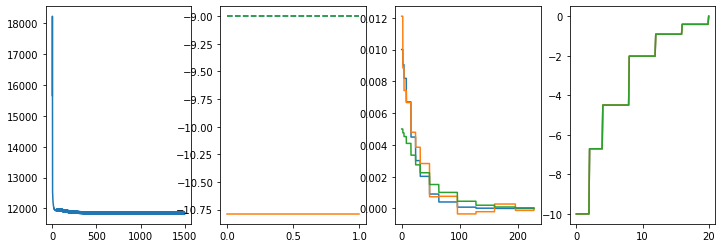

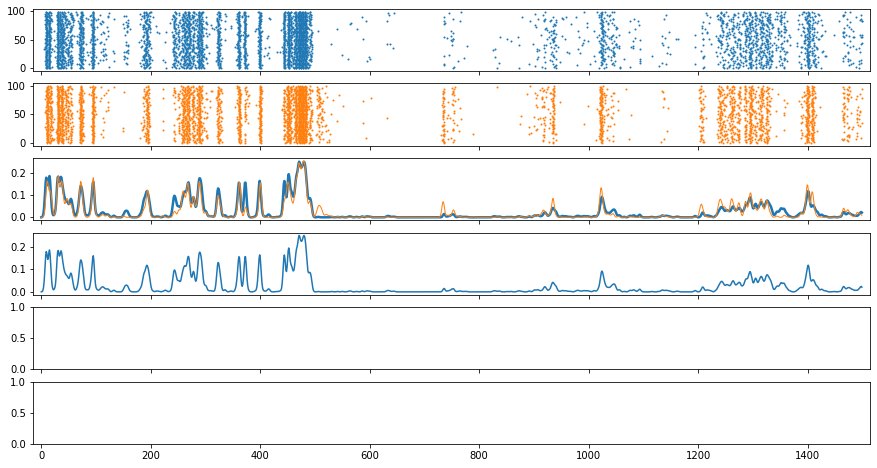

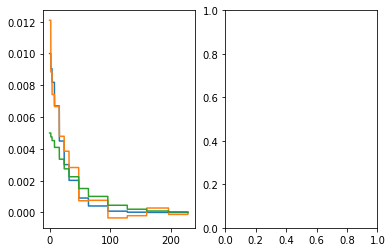

In [86]:
np.random.seed(0)

dt = 1
t = np.arange(0, 1500, 1)
# t1, t2 = 500, 1500
argt = 500

tbins_kappa = np.array([0, 2, 4, 8, 16, 24, 32, 48, 64, 96, 128, 160, 196, 228])
tbins_eta = np.array([0, 2, 4, 8, 12, 16, 20])

R = 2e-1
tau1, tau2 = 20, 40
# glm1 = GLM(u0=-10, kappa=KernelFun.single_exponential(tau1, A=R / tau1), eta=KernelFun.single_exponential(2, A=-7))
# glm2 = GLM(u0=-10, kappa=KernelFun.single_exponential(tau2, A=R / tau2), eta=KernelFun.single_exponential(2, A=-7))
glm1 = GLM(u0=-9, kappa=KernelRect(tbins_kappa, R / tau1 * np.exp(-tbins_kappa[:-1] / tau1)), 
           eta=KernelRect(tbins_eta, -10 * np.exp(-tbins_eta[:-1] / 5)))
glm2 = GLM(u0=-9, kappa=KernelRect(tbins_kappa, R / tau2 * np.exp(-tbins_kappa[:-1] / tau2)), 
           eta=KernelRect(tbins_eta, -10 * np.exp(-tbins_eta[:-1] / 5)))

r = 1
n = 200
n_train = 100

stim = np.zeros((len(t), 1))
# stim[:argt] = OUProcess(mu=0, sd=80, tau=3).sample(t[:argt], shape=(1,))
# stim[argt:] = OUProcess(mu=30, sd=30, tau=30).sample(t[:argt], shape=(1,))
stim[:argt] = OUProcess(mu=20, sd=60, tau=3).sample(t[:argt], shape=(1,))
a = 1.5
stim[argt:] = OUProcess(mu=10*a, sd=30*a, tau=3).sample(t[argt:], shape=(1,))
stim = np.stack([stim[:, 0]] * n, 1)

ker_gauss = KernelFun.gaussian_delta(2)
num_epochs = 1500

stim_train = stim[:, :n_train]
stim_val = stim[:, n_train:]

# v, mask_spikes_d = lif.sample(-65, t, stim, sigma=sigma)
_, _, mask_spikes_d1 = glm1.sample(t[:argt], stim=stim[:argt])
_, _, mask_spikes_d2 = glm2.sample(t[argt:], stim=stim[argt:])
print(np.mean(np.sum(mask_spikes_d1, 0)), np.mean(np.sum(mask_spikes_d2, 0)))
mask_spikes_d = np.concatenate((mask_spikes_d1, mask_spikes_d2), axis=0)
mask_spikes_d_train = mask_spikes_d[:, :n_train]
mask_spikes_d_val = mask_spikes_d[:, n_train:]

st_d = SpikeTrain(t, mask_spikes_d)
st_train = SpikeTrain(t, mask_spikes_d_train)
st_val = SpikeTrain(t, mask_spikes_d_val)

print(np.mean(np.sum(mask_spikes_d, 0)))

# glm_fit = TorchGLM(u0=-10, kappa=KernelRect(tbins_kappa, coefs=np.zeros(len(tbins_kappa) - 1) + 2e-3), 
#                    eta=KernelRect(tbins_eta, coefs=np.zeros(len(tbins_eta) - 1) - 10), noise='bernoulli')
glm_fit = TorchGLM(u0=(glm1.u0 + glm2.u0) / 2, kappa=glm1.kappa.copy(), eta=glm1.eta.copy(), noise='bernoulli')

# optim = Adam([{'params': glm_fit.b, 'lr': 4e-4}, 
#               {'params': glm_fit.kappa_coefs, 'lr': 1e-5}, 
#               {'params': glm_fit.eta_coefs, 'lr': 2e-4}
#               ], lr=1e-3, betas=(0, 0))

optim = SGD([{'params': glm_fit.b, 'lr': 4e-5}, 
              {'params': glm_fit.kappa_coefs, 'lr': 2e-10}, 
              ], lr=1e-10)

nll, metrics_list = glm_fit.train(t, torch.from_numpy(mask_spikes_d_train), stim=stim_train, optim=optim, num_epochs=num_epochs, 
                                   verbose=True, metrics=None)

# glm_fit2 = TorchGLM(u0=-10, kappa=glm1.kappa.copy(), eta=glm1.eta.copy(), noise='bernoulli')
# optim = Adam([{'params': glm_fit2.b, 'lr': 2e-2}, 
#               {'params': glm_fit2.kappa_coefs, 'lr': 1e-4}, 
#               {'params': glm_fit2.eta_coefs, 'lr': 2e-2}
#               ], lr=1e-3, betas=(0, 0))
# nll2, metrics_list2 = glm_fit2.train(t[:argt], mask_spikes_d_train[:argt], stim=stim_train[:argt], optim=optim, num_epochs=num_epochs, 
#                                    verbose=True, metrics=None)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(12, 4), ncols=4)
ax1.plot(nll)
ax2.plot([0, 1], [glm1.u0, glm1.u0], '--')
ax2.plot([0, 1], [glm_fit.u0, glm_fit.u0], '-')
ax2.plot([0, 1], [glm2.u0, glm2.u0], '--')
glm1.kappa.plot(ax=ax3)
glm_fit.kappa.plot(ax=ax3)
glm2.kappa.plot(ax=ax3)
glm1.eta.plot(ax=ax4)
glm_fit.eta.plot(ax=ax4)
glm2.eta.plot(ax=ax4)

u_fr, r_fr, mask_spikes_fr = glm_fit.sample(t, stim=stim_train)
u_dc, r_dc = glm_fit.sample_conditioned(t, mask_spikes_d_train, stim=stim_train)
st_fr = SpikeTrain(t, mask_spikes_fr)

u_fr2, r_fr2, mask_spikes_fr2 = glm_fit2.sample(t, stim=stim_train)
st_fr2 = SpikeTrain(t, mask_spikes_fr2)

psth_d = np.mean(st_train.convolve(ker_gauss), 1)
psth_fr = np.mean(st_fr.convolve(ker_gauss), 1)
psth_fr2 = np.mean(st_fr2.convolve(ker_gauss), 1)

print('\nerror total', np.sum((psth_d - psth_fr)**2))
print('error 1st part', np.sum((psth_d[:argt] - psth_fr[:argt])**2))
print('error 2nd part', np.sum((psth_d[argt:] - psth_fr[argt:])**2))
print('\nerror total 2', np.sum((psth_d - psth_fr2)**2))
print('error 1st part 2', np.sum((psth_d[:argt] - psth_fr2[:argt])**2))
print('error 2nd part 2', np.sum((psth_d[argt:] - psth_fr2[argt:])**2))

print('n_spikes', np.mean(np.sum(mask_spikes_fr, 0)))

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(15, 8), nrows=6, sharex=True)
st_train.plot(ax=ax1, ms=1)
st_fr.plot(ax=ax2, ms=1, color='C1')
ax3.plot(t, psth_d, lw=2.5)
ax3.plot(t, psth_fr, lw=1)
# ax3.plot(t, psth_fr2, lw=0.5, alpha=1)
ax4.plot(t, psth_d)

fig, (ax1, ax2) = plt.subplots(ncols=2)
glm1.kappa.plot(ax=ax1)
glm_fit.kappa.plot(ax=ax1)
glm2.kappa.plot(ax=ax1)

np.savez('reliability4', glm_u0=glm_fit.u0, glm_tbins_kappa=glm_fit.kappa.tbins, glm_coefs_kappa=glm_fit.kappa.coefs, 
         glm_tbins_eta=glm_fit.eta.tbins, glm_coefs_eta=glm_fit.eta.coefs, t=t, mask_spikes_d=mask_spikes_d, stim=stim, 
         mask_spikes_fr=mask_spikes_fr, u_dc=u_dc, u_fr=u_fr, r_dc=r_dc, r_fr=r_fr, log_likelihood=nll)

In [84]:
print(glm2.u0)

-9


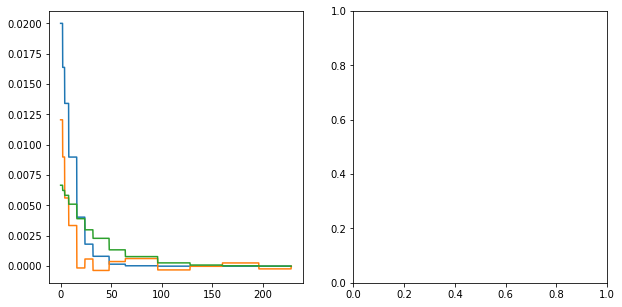

In [191]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
glm1.kappa.plot(ax=ax1)
glm_fit.kappa.plot(ax=ax1)
glm2.kappa.plot(ax=ax1)

-7.591379604984659


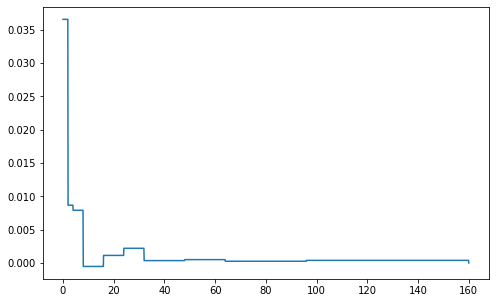

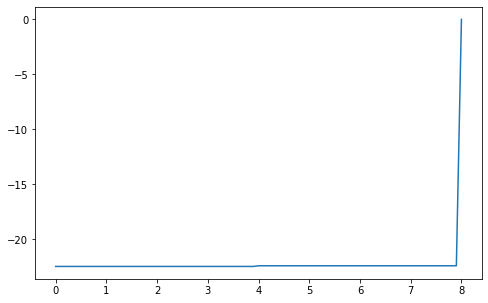

In [51]:
print(glm_fit.u0)
glm_fit.kappa.plot()
glm_fit.eta.plot()

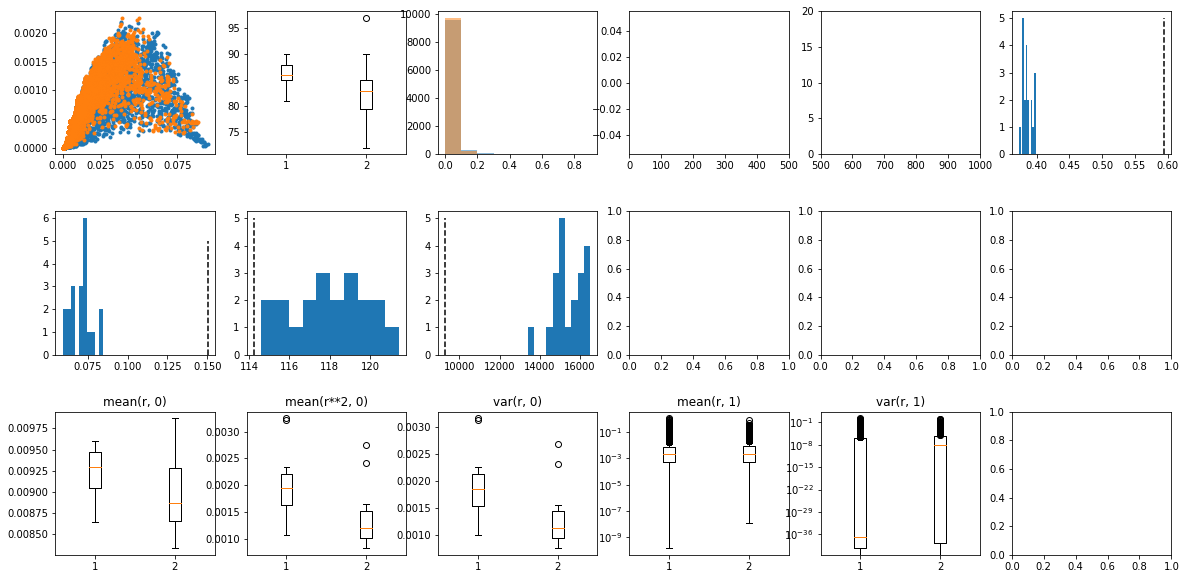

In [20]:
ker = KernelFun.gaussian_delta(4)

rel_te = st_te.reliability(ker, ker)
fano_te = np.mean(st_te.sliding_fano_factor(ker))
rels, fanos = [], []
mean_isis, var_isis = [], []
for ii in range(20):
    _u_fr, _r_fr, _mask_spikes_fr = glm_fit.sample(t, stim=stim)
    _st = SpikeTrain(t, _mask_spikes_fr)
    rels.append(_st.reliability(ker, ker))
    fanos.append(np.mean(_st.sliding_fano_factor(ker)))
    _isi_fr = _st.isi_distribution()
    mean_isis.append(np.mean(_isi_fr))
    var_isis.append(np.var(_isi_fr))

mean_spk_te = st_te.convolve(ker)
mean_spk_fr = st_fr.convolve(ker)
var_spk_te = np.var(mean_spk_te, 1)
var_spk_fr = np.var(mean_spk_fr, 1)
mean_spk_te = np.mean(mean_spk_te, 1)
mean_spk_fr = np.mean(mean_spk_fr, 1)

bins = np.arange(0, 1050, 50)
isi_te = st_te.isi_distribution()
mean_isi_te, var_isi_te = np.mean(isi_te), np.var(isi_te)
isi_fr = st_fr.isi_distribution()

fig, ((ax1, ax2, ax3, ax4, ax5, ax6), (ax7, ax8, ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16, ax17, ax18)) = plt.subplots(figsize=(20, 10), nrows=3, ncols=6)
fig.subplots_adjust(hspace=0.4)
ax1.plot(mean_spk_te, var_spk_te, '.')
ax1.plot(mean_spk_fr, var_spk_fr, '.')

m1, m2 = np.sum(mask_spikes_te, 0), np.sum(mask_spikes_fr, 0)
ax2.boxplot(x=(m1, m2));
m1, m2 = np.mean(mask_spikes_te, 1), np.mean(mask_spikes_fr, 1)
bins = np.arange(0, 1, .1)
ax3.hist(m1, alpha=0.5, bins=bins);
ax3.hist(m2, alpha=0.5, bins=bins);

ax4.hist(isi_te, bins=bins, alpha=0.5);
ax4.hist(isi_fr, bins=bins, alpha=0.5);
ax4.set_xlim(0, 500)
ax5.hist(isi_te, bins=bins, alpha=0.5);
ax5.hist(isi_fr, bins=bins, alpha=0.5);
ax5.set_xlim(500, 1000)
ax5.set_ylim(0, 20)

ax6.hist(rels)
ax6.plot([rel_te, rel_te], [0, 5], 'k--')
ax7.hist(fanos)
ax7.plot([fano_te, fano_te], [0, 5], 'k--')

ax8.hist(mean_isis)
ax8.plot([mean_isi_te, mean_isi_te], [0, 5], 'k--')
ax9.hist(var_isis)
ax9.plot([var_isi_te, var_isi_te], [0, 5], 'k--')

r1, r2 = np.mean(r_te, 0), np.mean(r_fr, 0)
ax13.boxplot(x=(r1, r2))
ax13.set_title('mean(r, 0)')

r1, r2 = np.mean(r_te**2, 0), np.mean(r_fr**2, 0)
ax14.boxplot(x=(r1, r2))
ax14.set_title('mean(r**2, 0)')

r1, r2 = np.var(r_te, 0), np.var(r_fr, 0)
ax15.boxplot(x=(r1, r2))
ax15.set_title('var(r, 0)')
# ax14.set_yscale('log')

r1, r2 = np.mean(r_te, 1), np.mean(r_fr, 1)
ax16.boxplot(x=(r1, r2))
ax16.set_title('mean(r, 1)')
ax16.set_yscale('log')

r1, r2 = np.var(r_te, 1), np.var(r_fr, 1)
ax17.boxplot(x=(r1, r2))
ax17.set_title('var(r, 1)')
ax17.set_yscale('log')